# Airlines Data Challenge

You are working for an airline company looking to enter the United States domestic market. Specifically, the company has decided to start with 5 round trip routes between medium and large US airports. An example of a round trip route is the combination of JFK to ORD and ORD to JFK. The airline company has to acquire 5 new airplanes (one per round trip route) and the upfront cost for each airplane is $90 million. The company’s motto is “On time, for you”, so punctuality is a big part of its brand image.
You have been tasked with analyzing 1Q2019 data to identify:
1. The 10 busiest round trip routes in terms of number of round trip flights in the quarter.
Exclude canceled flights when performing the calculation.
2. The 10 most profitable round trip routes (without considering the upfront airplane cost) in
the quarter. Along with the profit, show total revenue, total cost, summary values of other key components and total round trip flights in the quarter for the top 10 most profitable routes. Exclude canceled flights from these calculations.
3. The 5 round trip routes that you recommend to invest in based on any factors that you choose.
4. The number of round trip flights it will take to breakeven on the upfront airplane cost for each of the 5 round trip routes that you recommend. Print key summary components for these routes.
5. Key Performance Indicators (KPI’s) that you recommend tracking in the future to measure the success of the round trip routes that you recommend.

# Loading Requried Packages    

In [215]:
import pandas as pd
import numpy as np
import missingno as msno
import dateutil.parser 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Flights Dataset - Data Exploration, Data Cleaning, Data Wrangling

In [216]:
df_flights=pd.read_csv('Flights.csv')

/var/folders/ly/t_7n7hg94c7859vtjnbp3s2h0000gn/T/ipykernel_51815/4278860552.py:1: DtypeWarning: Columns (3,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_flights=pd.read_csv('Flights.csv')


In [217]:
# According to the given instructions, Filter out canceled flights from the flights data.

df_flights = df_flights[df_flights['CANCELLED'] == 0.0]


In [218]:
df_flights.dtypes

FL_DATE               object
OP_CARRIER            object
TAIL_NUM              object
OP_CARRIER_FL_NUM     object
ORIGIN_AIRPORT_ID      int64
ORIGIN                object
ORIGIN_CITY_NAME      object
DEST_AIRPORT_ID        int64
DESTINATION           object
DEST_CITY_NAME        object
DEP_DELAY            float64
ARR_DELAY            float64
CANCELLED            float64
AIR_TIME              object
DISTANCE              object
OCCUPANCY_RATE       float64
dtype: object

* As per the above information,  FL_DATE is a temporal data it should be converted to datetime format.
* OP_CARRIER, TAIL_NUM, OP_CARRIER_FL_NUM, ORIGIN_AIRPORT_ID, DEST_AIRPORT_ID, ORIGIN, DESTINATION are categorical data. They represent airline code, flight number, airport names, etc.
* AIR_TIME, DISTANCE are in Object type, which indicates these columns might have non-numerics characters. These columns need further investigation and coverted to appropiate numeric.




<Axes: >

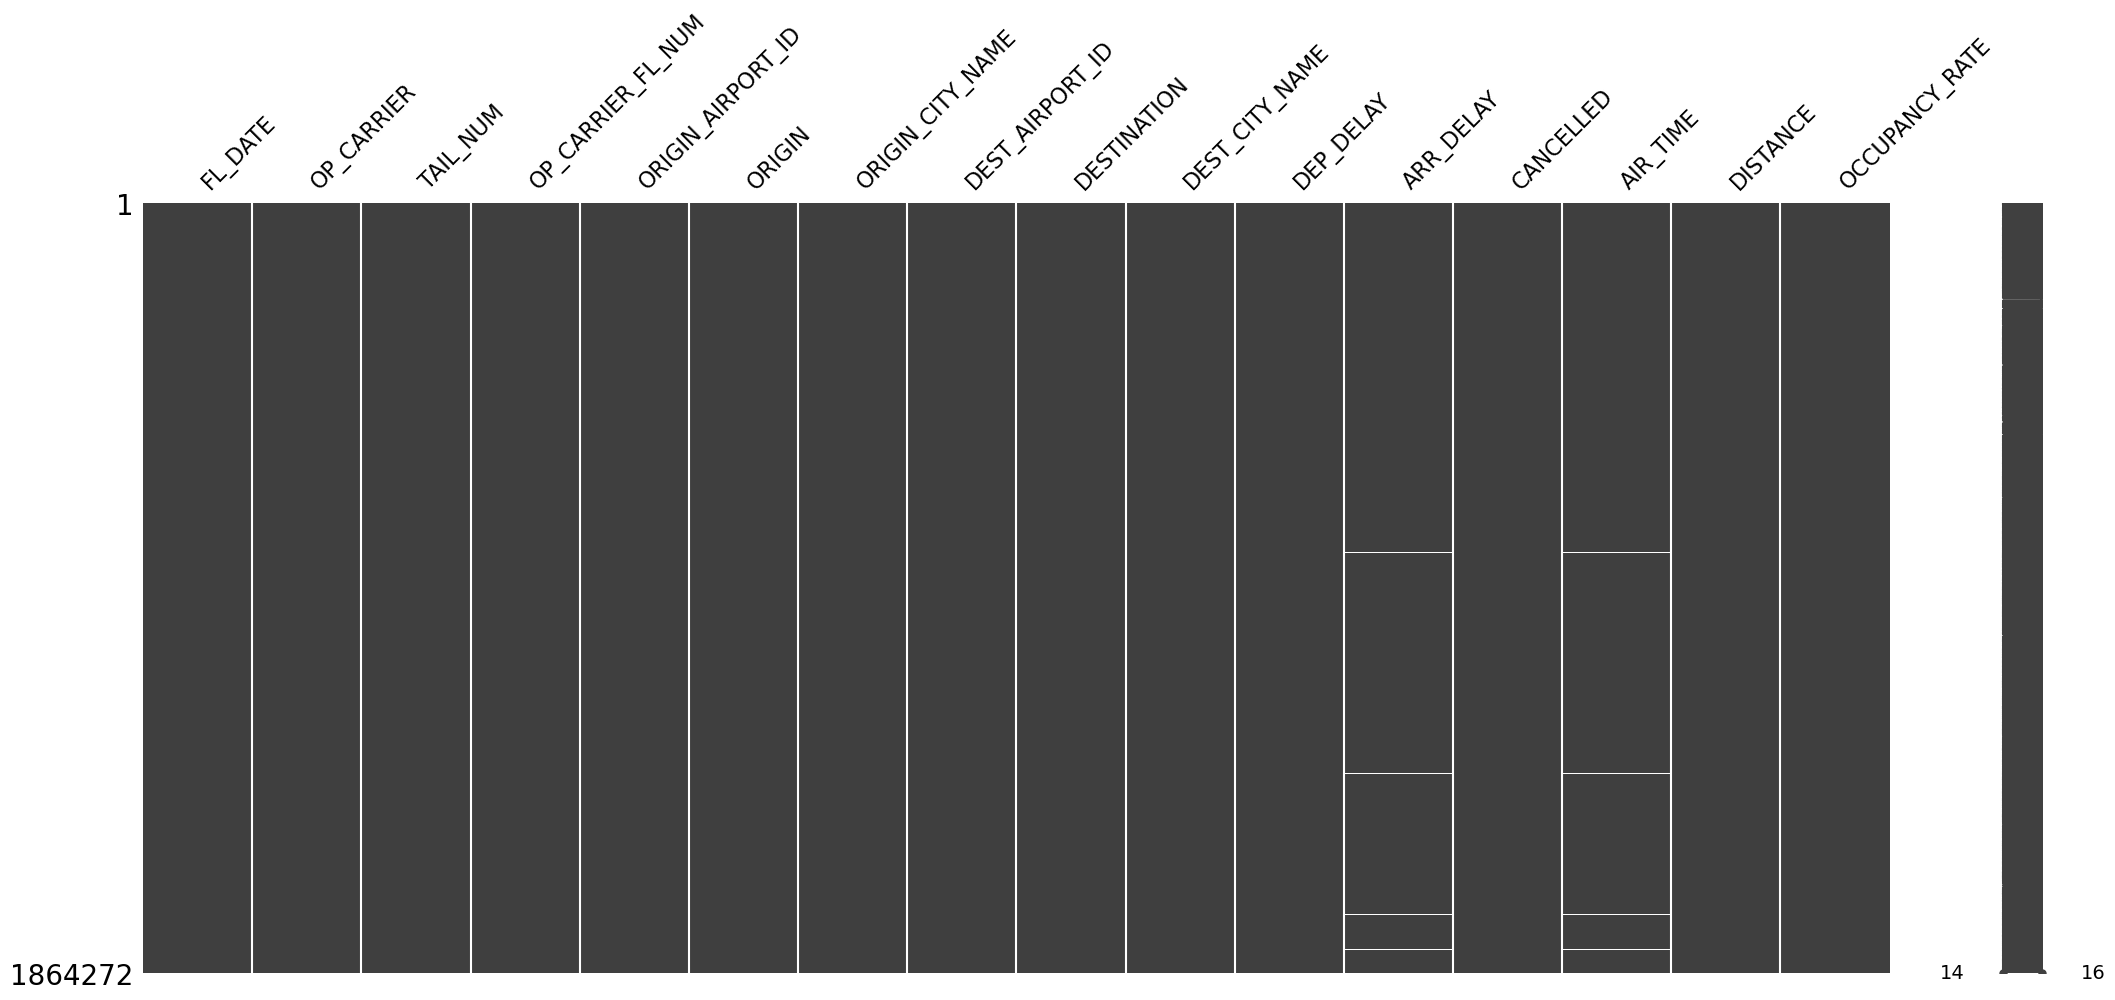

In [219]:
# Lets check if flights data have any NaN values and its relation with other columns.

msno.matrix(df_flights)

* The white gaps in the dark columns represents NaN values in each column. AIR_TIME and ARR_DELAY have significant issues during data collection or entry. The dataset require cleaning to handle these missing values appropriately, either by imputation or by droping these rows.

In [220]:
missing_values = df_flights.isnull().sum()
missing_values

FL_DATE                 0
OP_CARRIER              0
TAIL_NUM                0
OP_CARRIER_FL_NUM       0
ORIGIN_AIRPORT_ID       0
ORIGIN                  0
ORIGIN_CITY_NAME        0
DEST_AIRPORT_ID         0
DESTINATION             0
DEST_CITY_NAME          0
DEP_DELAY               0
ARR_DELAY            4377
CANCELLED               0
AIR_TIME             5027
DISTANCE              610
OCCUPANCY_RATE        310
dtype: int64

In [221]:
# FL_DATE column is in inconsistent format, so we are converting into one single date format.
df_flights['FL_DATE'] = df_flights['FL_DATE'].apply(dateutil.parser.parse)


# Creating a new column with day_name.
# This column is used to impute missing values in the columns assuming each day have different business dynamics.
df_flights['DAY_NAME']=df_flights['FL_DATE'].dt.day_name()


In [222]:
# Function to create a standardized route identifier.
def create_standard_route(origin, destination):
    """
    Creates a standardized route identifier by sorting and joining the origin and destination airport codes.
    
    Parameters:
    origin (str): The origin airport code.
    destination (str): The destination airport code.

    Returns:
    str: A standardized route identifier.
    """
    return '-'.join(sorted([origin, destination]))


# Apply create_standard_route function to create route column

df_flights['ROUTE'] = df_flights.apply(lambda x: create_standard_route(x['ORIGIN'], x['DESTINATION']), axis=1)


#### Assumption
Lets assume positive delay values as delay time, as these indicate actual delay, while negative or zero values indicated ontime or early departure. Lets only consider DEP_DELAY and ARR_DELAY greatethan zero


In [223]:
#  Here we are transforming Delay minutes less than zero to zero for further analysis. 
df_flights['DEP_DELAY'] = df_flights['DEP_DELAY'].apply(lambda x: x if x > 0 else 0)
df_flights['ARR_DELAY'] = df_flights['ARR_DELAY'].apply(lambda x: x if x > 0 else 0)

In [224]:
def impute_missing_values(df, column, groupby_columns, aggregation_method):
    """
     Imputes missing values in the specified column of a DataFrame based on an aggregation 
     (mean, median, etc.) of that column grouped by other specified columns.

     :param df: DataFrame to process.
     :param column: Name of the column to impute missing values.
     :param groupby_columns: List of column names to group by for calculating the aggregation.
     :param aggregation_method: Method of aggregation ('mean', 'median', etc.).

     :return: DataFrame with imputed values.
    """

    # Convert column to a numeric type, coercing errors to NaN
    df[column] = pd.to_numeric(df[column], errors='coerce')

    # Calculate the specified aggregation for the specified column grouped by the provided columns
    if aggregation_method == 'mean':
        aggregated_values = df.groupby(groupby_columns)[column].mean()
    elif aggregation_method == 'median':
        aggregated_values = df.groupby(groupby_columns)[column].median()


    # Function to fill missing values
    def fill_missing(row):
        if pd.isna(row[column]):
            return aggregated_values.get(tuple(row[name] for name in groupby_columns))
        else:
            return row[column]

    # Apply the function to each row
    df[column] = df.apply(fill_missing, axis=1)

    return df


In [225]:
# By using the Function defined above.

# Imputing AIR_TIME by mean values 

df_flights = impute_missing_values(df_flights, 'AIR_TIME', ['ORIGIN', 'DESTINATION', 'OP_CARRIER', 'TAIL_NUM'], 'mean')

# Imputing ARR_DELAY by Median values 

df_flights = impute_missing_values(df_flights, 'ARR_DELAY', ['ORIGIN', 'DESTINATION', 'OP_CARRIER', 'DAY_NAME'], 'median')


# Imputing DISTANCE by Median values 

df_flights = impute_missing_values(df_flights, 'DISTANCE', ['ORIGIN', 'DESTINATION', 'OP_CARRIER'], 'median')

# Imputing OCCUPANCY_RATE by Mean values 

df_flights = impute_missing_values(df_flights, 'OCCUPANCY_RATE', ['ORIGIN', 'DESTINATION', 'OP_CARRIER','DAY_NAME'], 'mean')



In [226]:
# Now dropping the rows which are having atleast one NaN value after applying impute_missing_values

df_flights=df_flights.dropna()  # Final df_Flights Table 
df_flights.columns

Index(['FL_DATE', 'OP_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM',
       'ORIGIN_AIRPORT_ID', 'ORIGIN', 'ORIGIN_CITY_NAME', 'DEST_AIRPORT_ID',
       'DESTINATION', 'DEST_CITY_NAME', 'DEP_DELAY', 'ARR_DELAY', 'CANCELLED',
       'AIR_TIME', 'DISTANCE', 'OCCUPANCY_RATE', 'DAY_NAME', 'ROUTE'],
      dtype='object')

# Airport Dataset - Data Exploration, Data Cleaning, Data Wrangling

In [227]:
df_airports=pd.read_csv('Airport_Codes.csv')

In [228]:
# Data Filteration according to problem statement
# Filtering Data based on 'US' and TYPE in['large_airport','medium_airport']

df_airports = df_airports[(df_airports['ISO_COUNTRY'] == 'US') 
                                & ((df_airports['TYPE'] == 'large_airport')|(df_airports['TYPE'] == 'medium_airport'))]


In [229]:
# Split coordinates columns into Latitude and Longitude from Coordinates
df_airports[['LATITUDE', 'LONGITUDE']] = df_airports['COORDINATES'].str.split(',', expand=True)


# Selecting only few columns which are necessary for further analysis
df_airports=df_airports[['IATA_CODE','NAME','TYPE','LATITUDE','LONGITUDE']]

In [230]:
missing_values = df_airports.isnull().sum()
missing_values

IATA_CODE    37
NAME          0
TYPE          0
LATITUDE      0
LONGITUDE     0
dtype: int64

As this is a dimensional dataset, We cannot impute NAN IATA_CODE without external datasource. The only way is to Drop those rows.

In [231]:
# Now dropping the rows which are having atleast one NaN value

df_airports=df_airports.dropna() # Final df_airports Table


# Tickets Dataset - Data Exploration, Data Cleaning, Data Wrangling

In [232]:
df_tickets=pd.read_csv('Tickets.csv')

In [233]:
# Data Filteration according to problem statement
df_tickets = df_tickets[(df_tickets['ROUNDTRIP'] == 1.0) 
                               & (df_tickets['YEAR'] == 2019) 
                               & (df_tickets['QUARTER'] == 1)]


# Selecting Required Columns only for further analysis. 

df_tickets=df_tickets[['ORIGIN','DESTINATION','REPORTING_CARRIER','ITIN_FARE']]

In [234]:
missing_values = df_tickets.isnull().sum()
missing_values

ORIGIN                 0
DESTINATION            0
REPORTING_CARRIER      0
ITIN_FARE            560
dtype: int64

In [235]:
df_tickets = impute_missing_values(df_tickets, 'ITIN_FARE', ['ORIGIN', 'DESTINATION', 'REPORTING_CARRIER'], 'mean')

In [236]:
missing_values = df_tickets.isnull().sum()
missing_values


ORIGIN                0
DESTINATION           0
REPORTING_CARRIER     0
ITIN_FARE            65
dtype: int64

In [237]:
# Now dropping the rows which are having atleast one NaN value

df_tickets=df_tickets.dropna() # Final df_tickets Table 



In [238]:
# Now grouping the df_tickets_based on routes and reporting_carrier

df_tickets = df_tickets.groupby(['ORIGIN', 'DESTINATION'])['ITIN_FARE'].mean().reset_index()


# Data Preparation

### Data Joining 

In [239]:
# First inner Join Between Flights and Airports datasets on ORIGIN and IATA_CODE columns

joined_df = pd.merge(df_flights, df_airports, how='inner', left_on='ORIGIN', right_on='IATA_CODE')


# Rename Columns After the first_inner_join

joined_df = joined_df.rename(columns={"NAME": "ORIGIN_AIRPORT_NAME", "TYPE": "ORIGIN_TYPE", "LATITUDE": "ORIGIN_LATITUDE", "LONGITUDE": "ORIGIN_LONGITUDE"}, errors="raise")


In [240]:
# Second inner Join Between Joined dataset and Airports dataset on DESTINATION and IATA_CODE columns

joined_df = pd.merge(joined_df, df_airports, how='inner', left_on='DESTINATION', right_on='IATA_CODE')


# Rename Columns After the Second_inner_join

joined_df =joined_df.rename(columns={"NAME": "DESTINATION_AIRPORT_NAME", "TYPE": "DESTINATION_TYPE", "LATITUDE": "DESTINATION_LATITUDE", "LONGITUDE": "DESTINATION_LONGITUDE"}, errors="raise")





In [241]:
# Now join joined_df with tickets dataset to get tickets price

# Assuming flights_df and tickets_df are your existing DataFrames

# Perform an inner join on multiple columns
result_df = pd.merge(joined_df, df_tickets, how='inner', 
                     left_on=['ORIGIN', 'DESTINATION'], 
                     right_on=['ORIGIN', 'DESTINATION'])



In [242]:
# Selecting few columns for further analysis

final_df=result_df[['FL_DATE','DAY_NAME','ROUTE','ORIGIN','ORIGIN_AIRPORT_NAME','ORIGIN_CITY_NAME','ORIGIN_TYPE','ORIGIN_LATITUDE','ORIGIN_LONGITUDE','DESTINATION','DESTINATION_AIRPORT_NAME','DESTINATION_TYPE','DESTINATION_LATITUDE','DESTINATION_LONGITUDE','DEP_DELAY','ARR_DELAY','AIR_TIME','DISTANCE','OCCUPANCY_RATE','ITIN_FARE']]
# final_df.columns

### Defining Functions to Calculate Cost and Revenue 

In [243]:
def calculate_operational_cost(airport_type):
    """
    Calculate the operational cost based on the airport type.

    Parameters:
    airport_type (str): Type of the airport ('medium' or 'large').

    Returns:
    int: Operational cost for the airport.
    """
    if airport_type.lower() == 'medium_airport':
        return airport_cost_medium
    elif airport_type.lower() == 'large_airport':
        return airport_cost_large
    else:
        return 0  # Assuming no cost for other types, can be adjusted as needed


In [244]:
def calculate_delay_cost(delay):
    """
    Calculate the delay cost based on DEP_DELAY and ARR_DELAY.

    Parameters:
    delay (float): minutes it got delayed.

    Returns:
    float: Delay cost for the flight.
    """
    if delay > 15: 
        return (delay-15)*delay_cost_per_minute
    else:
        return 0

In [245]:
def calculate_maintenance(distance):
    """
    Calculate the maintenance cost based on fuel, oil, Crew, insurance, others.

    Parameters:
    distance (float): distance in miles.

    Returns:
    float: maintenance cost for the flight.
    """
    
    return cost_per_mile*distance
    

In [246]:
def calculate_ticket_revenue(ticket_price, occupancy_rate):
    """
    Calculate the ticket revenue for a flight.

    Parameters:
    ticket_price (float): The price of a single ticket.
    occupancy_rate (float): The occupancy rate of the flight (as a fraction).

    Returns:
    float: Total ticket revenue for the flight.
    """
    
    return plane_capacity * occupancy_rate * ticket_price

In [247]:
def calculate_baggage_revenue(occupancy_rate):
    """
    Calculate the baggage revenue for a flight.

    Parameters:
    plane_capacity (float): occupancy rate of the fligh.

    Returns:
    float: Baggage revenue of the flight.
    """    
    
    return occupancy_baggage_fee * plane_capacity *occupancy_rate* baggage_fee_round_trip


In [248]:
# LETS DEFINE GLOBAL VARIABLES BASED ON GIVEN ASSUMPTIONS 
cost_per_mile = 8 + 1.18
airport_cost_medium = 5000
airport_cost_large = 10000
delay_cost_per_minute = 75
plane_capacity = 200  # Replace with actual ticket price per seat
occupancy_baggage_fee = 0.5  # 50% of passengers
baggage_fee_round_trip = 70

### Calculating Cost and Revenue 

In [249]:
# Cost to operate the FLight 

# Operational cost which include fixed service cost based on Medium and Large airport 
final_df['OPERATION_COST'] = final_df['ORIGIN_TYPE'].apply(calculate_operational_cost) + final_df['DESTINATION_TYPE'].apply(calculate_operational_cost)

# Delay cost based on flights delay arrival or departure 
final_df['DELAY_COST']=final_df['DEP_DELAY'].apply(calculate_delay_cost)+final_df['ARR_DELAY'].apply(calculate_delay_cost)

# Maintenance cost based on oil, fuel, crew, deprication, insurance, others
final_df['MAINTENANCE_COST']=(final_df['DISTANCE'].apply(calculate_maintenance)).round(2)


# Total Cost to operate Aircraft
final_df['COST']=final_df['OPERATION_COST']+final_df['DELAY_COST']+final_df['MAINTENANCE_COST']




/var/folders/ly/t_7n7hg94c7859vtjnbp3s2h0000gn/T/ipykernel_51815/4168326120.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['OPERATION_COST'] = final_df['ORIGIN_TYPE'].apply(calculate_operational_cost) + final_df['DESTINATION_TYPE'].apply(calculate_operational_cost)
/var/folders/ly/t_7n7hg94c7859vtjnbp3s2h0000gn/T/ipykernel_51815/4168326120.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['DELAY_COST']=final_df['DEP_DELAY'].apply(calculate_delay_cost)+final_df['ARR_DELAY'].apply(cal

In [250]:
# Revenued generated by operating aircraft

# Revenue generated through ticket sales
final_df['TICKET_REVENUE'] = (final_df.apply(lambda x: calculate_ticket_revenue(x['ITIN_FARE'], x['OCCUPANCY_RATE']), axis=1)).round(2)

# Revenue generated throught baggage fee. 
final_df['BAGGAGE_FEE']=(final_df['OCCUPANCY_RATE'].apply(calculate_baggage_revenue)).round(2)


# Total Revenue generated by operating airline
final_df['REVENUE']=final_df['TICKET_REVENUE']+final_df['BAGGAGE_FEE']



/var/folders/ly/t_7n7hg94c7859vtjnbp3s2h0000gn/T/ipykernel_51815/2461707618.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['TICKET_REVENUE'] = (final_df.apply(lambda x: calculate_ticket_revenue(x['ITIN_FARE'], x['OCCUPANCY_RATE']), axis=1)).round(2)
/var/folders/ly/t_7n7hg94c7859vtjnbp3s2h0000gn/T/ipykernel_51815/2461707618.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['BAGGAGE_FEE']=(final_df['OCCUPANCY_RATE'].apply(calculate_baggage_revenue)).round(2)
/var/folders/ly/t_7n7hg94

In [251]:
# Profits generated 

final_df['PROFITS']=final_df['REVENUE']-final_df['COST']


/var/folders/ly/t_7n7hg94c7859vtjnbp3s2h0000gn/T/ipykernel_51815/2325087345.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['PROFITS']=final_df['REVENUE']-final_df['COST']


### Metadata of the Joined Dataframe for Further Analysis



| Column_Name              | Description |
|:-|:------------|
| FL_DATE                  | The date of the flight. |
| DAY_NAME                 | The day of the week on which the flight occurred. |
| ROUTE                    | A combination of the origin and destination airports representing the flight route. |
| ORIGIN                   | The airport IATA code of the flight's origin. |
| ORIGIN_AIRPORT_NAME      | The full name of the origin airport. |
| ORIGIN_CITY_NAME         | The name of the city where the origin airport is located. |
| ORIGIN_TYPE              | The type of the origin airport (e.g., Medium, Large). |
| ORIGIN_LATITUDE          | The geographic latitude of the origin airport. |
| ORIGIN_LONGITUDE         | The geographic longitude of the origin airport. |
| DESTINATION              | The airport IATA code of the flight's destination. |
| DESTINATION_AIRPORT_NAME | The full name of the destination airport. |
| DESTINATION_TYPE         | The type of the destination airport (e.g., Medium, Large). |
| DESTINATION_LATITUDE     | The geographic latitude of the destination airport. |
| DESTINATION_LONGITUDE    | The geographic longitude of the destination airport. |
| DEP_DELAY                | The delay in departure from the origin airport in minutes (positive for delay, negative for early departure). |
| ARR_DELAY                | The delay in arrival at the destination airport in minutes (positive for delay, negative for early arrival). |
| AIR_TIME                 | The duration of the flight in the air in minutes. |
| DISTANCE                 | The distance of the flight in miles. |
| OCCUPANCY_RATE           | The rate of occupancy of the flight (percentage of seats filled). |
| ITIN_FARE                | The itinerary fare for the flight. |
| OPERATION_COST           | The operating cost of the flight. |
| DELAY_COST               | The cost incurred due to delays. |
| MAINTENANCE_COST         | The maintenance cost for the flight. |
| COST                     | The total cost of the flight. |
| TICKET_REVENUE           | The revenue generated from ticket sales. |
| BAGGAGE_FEE              | Revenue generated from baggage fees. |
| REVENUE                  | The total revenue generated from the flight. |
| PROFITS                  | The total profits from the flight (revenue minus costs). |


# Top 10 Busiest round trip routes

In [252]:
# Grouping by 'round', counting the occurrences, sorting, and selecting the top 5
top_rounds = final_df.groupby(['ROUTE']).size().reset_index(name='COUNT_OF_FLIGHTS').sort_values(by='COUNT_OF_FLIGHTS', ascending=False).head(10)

top_rounds.reset_index(drop=True, inplace=True)
top_rounds

,ROUTE,COUNT_OF_FLIGHTS
0,LAX-SFO,8338
1,LGA-ORD,7156
2,LAS-LAX,6510
3,JFK-LAX,6318
4,LAX-SEA,4999
5,BOS-LGA,4819
6,HNL-OGG,4794
7,PDX-SEA,4774
8,ATL-MCO,4707
9,ATL-LGA,4594


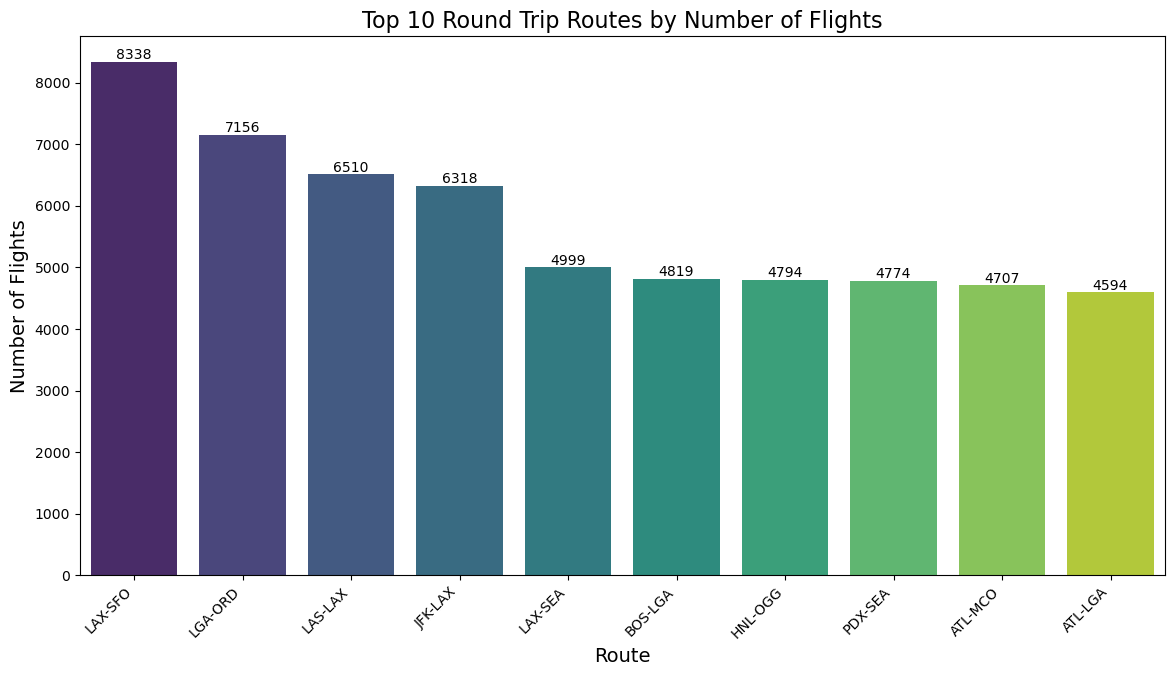

In [253]:
# Create a bar plot using Seaborn
plt.figure(figsize=(14, 7))
barplot = sns.barplot(x='ROUTE', y='COUNT_OF_FLIGHTS', data=top_rounds, palette='viridis')
barplot.bar_label(barplot.containers[0], fontsize=10);


# labels and title
plt.xlabel('Route', fontsize=14)
plt.ylabel('Number of Flights', fontsize=14)
plt.title('Top 10 Round Trip Routes by Number of Flights', fontsize=16)
plt.xticks(rotation=45, ha='right')

plt.show()

# Top 10 Profitable round trip routes

In [254]:

# Aggregating data for each route
agg_dollar = final_df.groupby(['ROUTE']).agg(
    total_revenue=('REVENUE', 'sum'),
    total_cost=('COST', 'sum'),
    total_flights=('ROUTE', 'count')
).reset_index()

# For better readability convert numbers into millions 
agg_dollar['total_revenue']=((agg_dollar['total_revenue'].astype('int64') )/1000000).round(2)
agg_dollar['total_cost']=((agg_dollar['total_cost'].astype('int64') )/1000000).round(2)



# Calculating profits for each route
agg_dollar['total_profits'] = (agg_dollar['total_revenue'] - agg_dollar['total_cost'])

# Sorting by profits and selecting the top 10 most profitable routes
top_10_profitable_routes = agg_dollar.sort_values(by=['total_profits','total_flights'], ascending=False).head(10)


top_10_profitable_routes.style.hide()

ROUTE,total_revenue,total_cost,total_flights,total_profits
JFK-LAX,813.910000,278.060000,6318,535.850000
SLC-TWF,355.930000,10.480000,582,345.450000
JFK-SFO,412.480000,170.860000,3721,241.620000
EWR-SFO,351.030000,112.340000,2421,238.690000
DCA-ORD,265.760000,100.980000,3693,164.780000
ATL-LGA,295.380000,130.840000,4594,164.540000
ATL-LAX,285.590000,122.160000,3197,163.430000
LGA-ORD,368.940000,213.210000,7156,155.730000
LAX-SFO,357.110000,214.610000,8338,142.500000
DCA-LGA,221.210000,80.710000,3359,140.500000


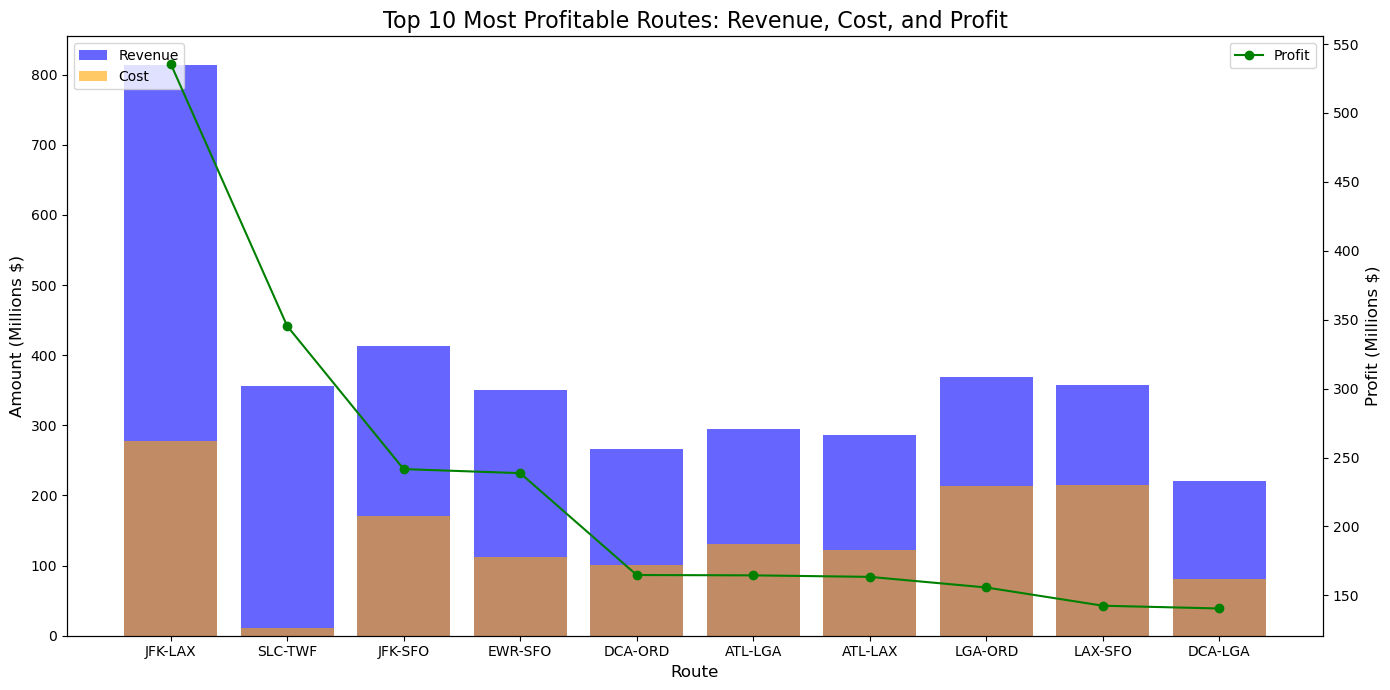

In [255]:
# Plotting the top 10 profitable routes
fig, ax1 = plt.subplots(figsize=(14, 7))

# Bar plot for revenue and cost
ax1.bar(top_10_profitable_routes['ROUTE'], top_10_profitable_routes['total_revenue'], label='Revenue', alpha=0.6, color='blue')
ax1.bar(top_10_profitable_routes['ROUTE'], top_10_profitable_routes['total_cost'], label='Cost', alpha=0.6, color='orange')

# Line plot for profit
ax2 = ax1.twinx()
ax2.plot(top_10_profitable_routes['ROUTE'], top_10_profitable_routes['total_profits'], label='Profit', color='green', marker='o')

# Labels and Title
ax1.set_xlabel('Route', fontsize=12)
ax1.set_ylabel('Amount (Millions $)', fontsize=12)
ax2.set_ylabel('Profit (Millions $)', fontsize=12)
ax1.set_title('Top 10 Most Profitable Routes: Revenue, Cost, and Profit', fontsize=16)

# Legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show plot
plt.tight_layout()
plt.show()

* JFK-LAX route has higest profits, there is a significant drop as we move to the next routes.
* From JFK-LAX route onwards, the profit line begins to level off, indicating more consistency in profits among the remaining routes.
* Even though revenue is high for all the routes, the ability to control costs seems to vary. For instance, JFK-LAX route has a relatively low cost compared to its revenue, whic boosts its profits. On the other hand ATL-LGA and LGA -ORD show narrow margins between revenue and cost.


# Route Recommendations

Lets use scoring system to evaluate each route. Each factor was normalized on a scale from 0 to 1,ensuring a fair comparison. We then assing weigths to each factor based on its importance to our business goals:

* **Punctuality (Less Delay)**: In keeping with our motto "On time, for you," we meticulously analyzed departure and arrival delays. Routes with the least average delays scored higher, reflecting our dedication to timely service.

* **Financial Health (More Profits)**: We assessed the profitability of each route. Higher profits directly contribute to our airline's growth and enable us to enhance our services, ensuring routes that bring in more revenue after costs are prioritized.

* **Operational Efficiency (Less Cost)**: Cost management is key to providing affordable services without compromising quality. Routes with lower operating costs scored better, indicating efficiency.

* **Demand (Most Frequent Routes)**: The frequency of flights on a route signifies demand. More flights mean more travelers trust our service, making these routes vital to our network.

In [256]:
# Calculate average delay per route, considering both departure and arrival delays
final_df['AVG_DELAY'] = (final_df['DEP_DELAY'] + final_df['ARR_DELAY']) / 2

# Group by ROUTE and calculate mean profits, mean costs, and count flights
route_scores = final_df.groupby('ROUTE').agg(
    AVG_DELAY=('AVG_DELAY', 'mean'),
    AVG_PROFITS=('PROFITS', 'mean'),
    AVG_COST=('COST', 'mean'),
    AVG_OCCUPANCY_RATE=('OCCUPANCY_RATE', 'mean'),
#     FLIGHT_COUNT=('FL_DATE', 'count')
).reset_index()

# Initialize a MinMaxScaler
scaler = MinMaxScaler()

# Scale the average delay inversely because lower delay is better
route_scores['SCALED_DELAY'] = 1 - scaler.fit_transform(route_scores[['AVG_DELAY']])

# Scale the profits, costs inversely, and flight count
route_scores['SCALED_PROFITS'] = scaler.fit_transform(route_scores[['AVG_PROFITS']])
route_scores['SCALED_COST'] = 1 - scaler.fit_transform(route_scores[['AVG_COST']])
route_scores['SCALED_OCCUPANCY_RATE'] = 1 - scaler.fit_transform(route_scores[['AVG_OCCUPANCY_RATE']])
# route_scores['SCALED_FLIGHT_COUNT'] = scaler.fit_transform(route_scores[['FLIGHT_COUNT']])

# Assign weights based on your criteria's importance
weights = {
    'DELAY': 0.4,
    'PROFITS': 0.4,
    'OCCUPANCY_RATE': 0.10,
    'COST': 0.10,

}

# Calculate the score for each route
route_scores['SCORE'] = (route_scores['SCALED_DELAY'] * weights['DELAY'] +
                         route_scores['SCALED_PROFITS'] * weights['PROFITS'] +
                         route_scores['SCALED_COST'] * weights['COST'] +
                         route_scores['SCALED_OCCUPANCY_RATE'] * weights['OCCUPANCY_RATE'])

# Sort by the calculated score in descending order to get the best routes on top
top_routes = route_scores.sort_values(by='SCORE', ascending=False)

# Select the top 5 routes
top_5_routes = top_routes.head(5)

# top_5_routes
top_5_routes.style.hide()

ROUTE,AVG_DELAY,AVG_PROFITS,AVG_COST,AVG_OCCUPANCY_RATE,SCALED_DELAY,SCALED_PROFITS,SCALED_COST,SCALED_OCCUPANCY_RATE,SCORE
SLC-TWF,12.116838,593564.595361,18005.211340,0.668041,0.943047,1.000000,0.928681,0.521169,0.922204
CLT-FLO,11.241036,244439.235777,17047.266215,0.642789,0.947163,0.428771,0.938261,0.569917,0.701191
MDT-PHL,10.822864,105032.555879,16885.755678,0.645754,0.949129,0.200677,0.939877,0.564194,0.610329
PIH-SLC,7.885185,97181.029630,17241.444444,0.649333,0.962937,0.187831,0.936319,0.557284,0.609667
EYW-ORD,11.559441,122852.755664,27620.718462,0.654126,0.945667,0.229834,0.832516,0.548032,0.608255


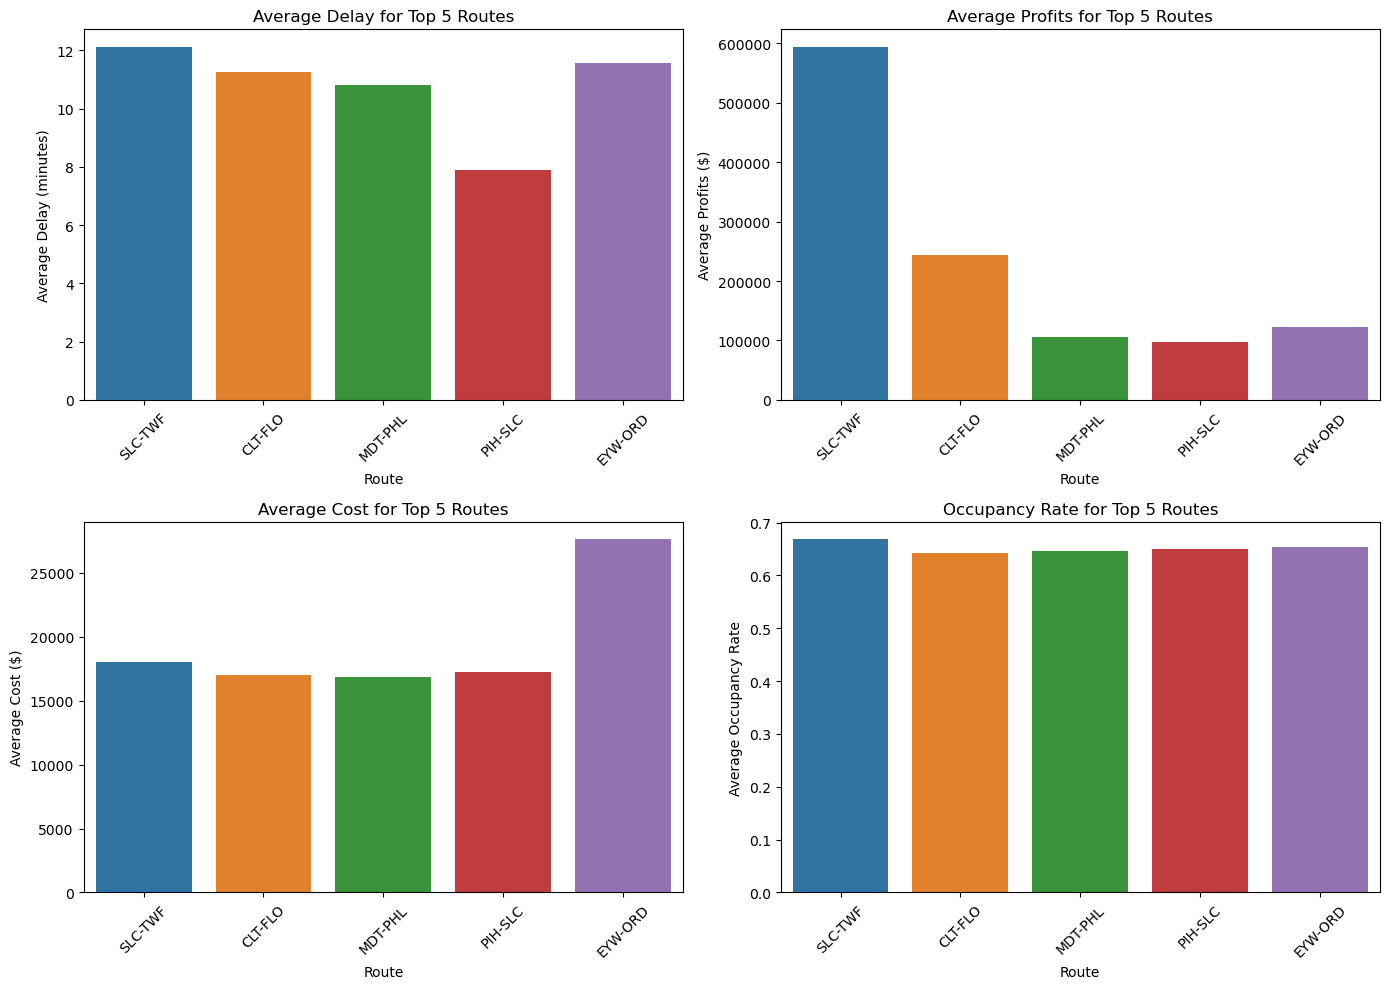

In [257]:
# Set up the matplotlib figure
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Rotate the labels on the x-axis for readability
plt.setp(axes, xticks=[], xticklabels=[])

# Plot Average Delay
sns.barplot(ax=axes[0, 0], x='ROUTE', y='AVG_DELAY', data=top_5_routes)
axes[0, 0].set_title('Average Delay for Top 5 Routes')
axes[0, 0].set_xlabel('Route')
axes[0, 0].set_ylabel('Average Delay (minutes)')

# Plot Average Profits
sns.barplot(ax=axes[0, 1], x='ROUTE', y='AVG_PROFITS', data=top_5_routes)
axes[0, 1].set_title('Average Profits for Top 5 Routes')
axes[0, 1].set_xlabel('Route')
axes[0, 1].set_ylabel('Average Profits ($)')

# Plot Average Cost
sns.barplot(ax=axes[1, 0], x='ROUTE', y='AVG_COST', data=top_5_routes)
axes[1, 0].set_title('Average Cost for Top 5 Routes')
axes[1, 0].set_xlabel('Route')
axes[1, 0].set_ylabel('Average Cost ($)')

# Plot Average Occupancy Rate
sns.barplot(ax=axes[1, 1], x='ROUTE', y='AVG_OCCUPANCY_RATE', data=top_5_routes)
axes[1, 1].set_title('Occupancy Rate for Top 5 Routes')
axes[1, 1].set_xlabel('Route')
axes[1, 1].set_ylabel('Average Occupancy Rate')

# Rotate x-axis labels
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()



* The SLC-TWF route is a standout performer, with the highest profitability and a strong occupancy rate, suggesting that it's a vital route for the airline.
* The CLT-FLO route, while not as profitable as SLC-TWF, still maintains a high occupancy rate, indicating reliable demand.
* The MDT-PHL route, despite its lower profitability, has the lowest average delay, which could enhance customer satisfaction and potentially lead to increased demand.
* The EWR-ORD route has the highest costs, which could be impacting its profitability. It might benefit from a detailed cost analysis to identify opportunities for savings.
* Routes like PHL-SLC show a balance between profitability and occupancy but may not excel in either, indicating potential for improvement.

# Breakeven Analysis

To calculate the breakeven number of round-trip flights for the recommended routes, you need to consider the upfront airplane cost and the Average profit per round-trip flight for each route. 

The formula for calculating the breakeven number of flights is:



\begin{gather*}
Breakeven flights = \frac{\text{Upfront Airplane Cost}}{\text{Average profit per round trip}}  
\end{gather*}

In [258]:
# Constants
AIRPLANE_COST = 90_000_000  # $90 million per airplane

# Calculate the breakeven number of flights for each recommended route
# Assuming 'AVG_PROFITS' represents the average profit per flight for each route
top_5_routes['BREAKEVEN_FLIGHTS'] = (AIRPLANE_COST / top_5_routes['AVG_PROFITS']).round()

# Display the recommended routes with their breakeven flights
top_5_routes[['ROUTE', 'BREAKEVEN_FLIGHTS']].style.hide()


/var/folders/ly/t_7n7hg94c7859vtjnbp3s2h0000gn/T/ipykernel_51815/4213956349.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_5_routes['BREAKEVEN_FLIGHTS'] = (AIRPLANE_COST / top_5_routes['AVG_PROFITS']).round()


ROUTE,BREAKEVEN_FLIGHTS
SLC-TWF,152.000000
CLT-FLO,368.000000
MDT-PHL,857.000000
PIH-SLC,926.000000
EYW-ORD,733.000000


# KPI's

* **On-Time Performance (OTP)**: Measure the punctuality of flights, as the company's motto emphasizes timeliness. This can be calculated as the percentage of flights departing or arriving within 15 minutes of their scheduled times.
$$ $$

* **Revenue Per Available Seat Mile (RASM)**: RASM provides clear picture of the revenue generating ability of an airlines relative to its capacity.

\begin{gather*}
RASM = \frac{\text{Revenue}}{\text{Distance * Maximum Seats}}  
\end{gather*}


* **Cost Per Available Seat Mile (CASM)**: This provides insights into how efficiently an airlines is controlling its cost relative to its availiable seat mile.

\begin{gather*}
CASM = \frac{\text{Total Operating Cost}}{\text{Distance * Maximum Seats}}  
\end{gather*}


* **Breakeven Load Factor**: This is the occupancy rate at which the revenue from passengers covers the operational cost of the flight. It's a critical metric for understanding the minimum performance needed to avoid losing money on a route.
\begin{gather*}
Breakeven Load Factor = \frac{\text{Total Fixed Cost}}{\text{Total Seat Revenue Potential}}  
\end{gather*}
$$ $$

* **Customer Satisfaction Score**: Though not directly mentioned in the data, customer satisfaction is crucial for long-term success. This can be measured through surveys and feedback mechanisms.

# Final Conclusion

In summary, our analysis has identified the top five routes for the airline's entry into the U.S. domestic market, focusing on profitability, punctuality, and cost efficiency. 

Recommended round trip routes:
* SLC - TWF
* CLT - FLO
* MDT - PHL
* PIH - SLC
* EYW - ORD	


###### Further analysis recommendation
There are several directions where we can expand our analysis further and imporve business.

* Analyze different revenue streams incluing ticket classes(First,Business,Economy) to optimize pricing strategies.
* Scrutinize customer behaviour data to plan marketing strategies and servies design based on booking patterns and preferences.
* Competitor analysis to understand competitor stratigies and desgin unique selling products.
* Examine Seasonal trends to better plan flight schedule and staffing, ensuring that we captilize in peak seasons.
* Assess the impact of external factors such as weather, economic conitions and political events on our operations.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 20.7 MB/s eta 0:00:0000:0100:01


Note: you may need to restart the kernel to use updated packages.
